In [ ]:
#Mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

**Read the data**

In [ ]:
path = '/content/drive/MyDrive/Kupra/text classification/Literales (1) copia.xlsx'
data = pd.read_excel(path,sheet_name=2)

In [ ]:
data.head()

,RUT,Pass,Literal,Categoría,INC,Conv,Fecha,Mercado,Detalle Merc,Global,Tarifa,Dispositivo,Viaje,Unnamed: 13
0,152641494,NaN,Debería tener una opción de chatear con person...,Servicio,NaN,0,2021-03-30 00:00:00.000,InalambricoTDE,NaN,1.0,Triple TV Super HD + TF + Int Pro 30 Mbps,Mobile,Ayuda y Soporte,NaN
1,13375492K,NaN,"Lento el sistema, no se notan para nada todos ...",servicio,NaN,1,2021-04-27 21:00:42.643,FibraTDE,NaN,2.0,NaN,Mobile,Ayuda y Soporte,NaN
2,157508288,NaN,Pésimo servicio de internet hogar,Servicio,NaN,1,2021-03-30 00:00:00.000,InalambricoTDE,NaN,1.0,Duo TV Super HD + Internet Pro 30 Mbps,Mobile,Ver Cuenta / Boleta,NaN
3,70759810,NaN,Estos últimos 6 meses estoy totalmente desconf...,Servicio,NaN,1,2021-03-30 00:00:00.000,ILM,NaN,1.0,Duo Telefonia Fija + Internet Pro 30 Mbps,Desktop,Otro Motivo,NaN
4,142197855,NaN,"Dificil de usar, no es claro.",UX,NaN,0,2021-03-31 00:00:00.000,ILM,NaN,1.0,Triple TV Super HD + TF + Int Pro 30 Mbps,Mobile,Otro Motivo,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880 entries, 0 to 2879
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   RUT           2876 non-null   object        
 1   Pass          371 non-null    object        
 2   Literal       2880 non-null   object        
 3   Categoría     2603 non-null   object        
 4   INC           66 non-null     object        
 5   Conv          1222 non-null   object        
 6   Fecha         2820 non-null   datetime64[ns]
 7   Mercado       2880 non-null   object        
 8   Detalle Merc  522 non-null    object        
 9   Global        2804 non-null   float64       
 10  Tarifa        2557 non-null   object        
 11  Dispositivo   2800 non-null   object        
 12  Viaje         2634 non-null   object        
 13  Unnamed: 13   1 non-null      float64       
dtypes: datetime64[ns](1), float64(2), object(11)
memory usage: 315.1+ KB


In [ ]:
#select only text & relevence columns
df = data[['Literal', 'Categoría']]

# Drop null values 
df = df.dropna()

### Distribution of Categoría

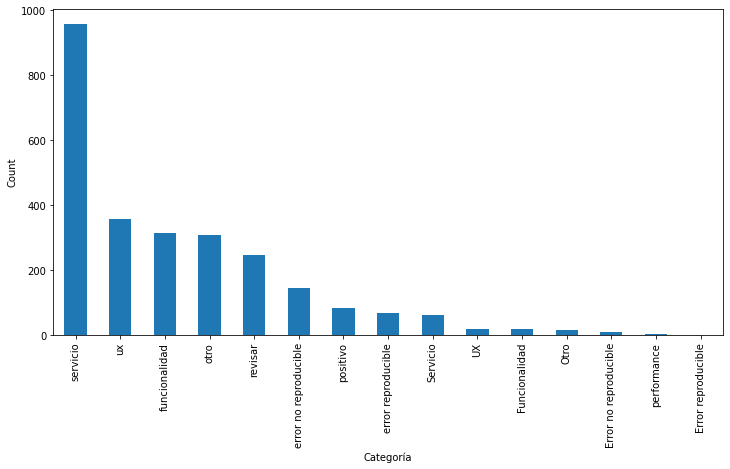

In [ ]:
plt.figure(figsize=(12,6))
df.Categoría.value_counts().plot.bar()
plt.xlabel('Categoría')
plt.ylabel('Count')
plt.show()

We can see that the categories UX & ux , servicio & Servicio, Funcionalidad &funcionalidad, Otro & otro, Error no reproducible & error no reproducible, Error reproducible & error reproducible. Since these pair of categories same, let's convert them to a single category.

In [ ]:
df['Categoría'] = df['Categoría'].replace({'Servicio': 'servicio', 'UX': 'ux', 'Funcionalidad': 'funcionalidad', 'Otro': 'otro',
                              'Error no reproducible':'error no reproducible','Error reproducible':'error reproducible'})
df.head()

,Literal,Categoría
0,Debería tener una opción de chatear con person...,servicio
1,"Lento el sistema, no se notan para nada todos ...",servicio
2,Pésimo servicio de internet hogar,servicio
3,Estos últimos 6 meses estoy totalmente desconf...,servicio
4,"Dificil de usar, no es claro.",ux


### Distribution of Categoría after cleaning

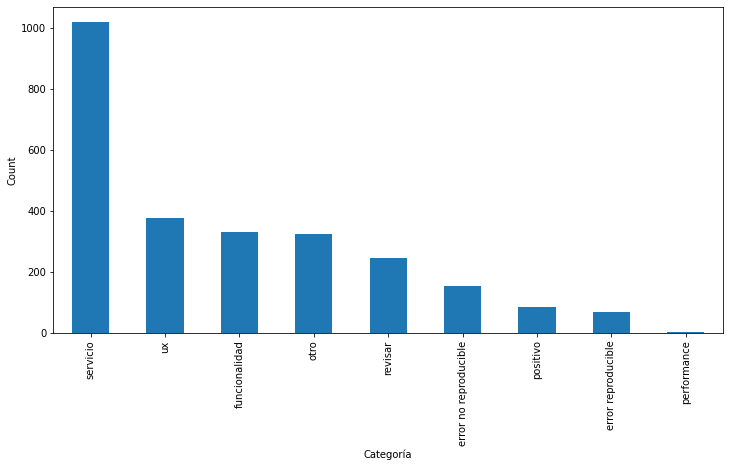

In [ ]:
plt.figure(figsize=(12,6))
df.Categoría.value_counts().plot.bar()
plt.xlabel('Categoría')
plt.ylabel('Count')
plt.show()

From the above plot we can say that, the performance category doesn't have sufficient number of samples. It will have detrimental impact on the model performance. So, let's drop that category. Also, the data is highly imbalanced.

In [ ]:
df = df[df['Categoría']!='performance'].reset_index(drop=True)

### Encode the Categoría feature

In [ ]:
# Consider class 0,1,2,3,4,5,6,7
def change_label(label):
    if label=='servicio':
        return 0
    elif label=='ux':
        return 1
    elif label=='funcionalidad':
        return 2
    elif label=='otro':
        return 3
    elif label=='revisar':
        return 4
    elif label=='error no reproducible':
        return 5
    elif label=='positivo':
        return 6
    elif label=='error reproducible':
        return 7
     
df['Categoría'] = df['Categoría'].apply(change_label)

In [ ]:
# Create features & labels
X = df['Literal']             # Features
y = df['Categoría']           # labels

**Train-Validation-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
# Split the train into train (90%),val (5%) & test sets(5%).
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42, stratify=y_val)

print(f'Train shape : {x_train.shape}')
print(f'Validation shape : {x_val.shape}')
print(f'Testing shape : {x_test.shape}')

Train shape : (2339,)
Validation shape : (130,)
Testing shape : (130,)


In [ ]:
# Number of samples in each class in labels
y_train.value_counts()

0    915
1    338
2    297
3    291
4    221
5    139
6     76
7     62
Name: Categoría, dtype: int64

**GPU & Transformer Setup**

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


**Install huggingface transformers.**

We use huggingface transformers to build BERT model for text classification.

In [ ]:
!pip install transformers

**Data Preprocessing**

You might already know that Machine Learning models don’t work with raw text. You need to convert text to numbers. BERT requires even more attention because it is a state of the art language model. Here are the requirements:
* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask to differentiate padded tokens from real tokens.    

The Transformers library provides a wide variety of Transformer models (including BERT).It works with TensorFlow and PyTorch!. We are using Pytorch for this task.    

In first step we need to convert the raw text to numbers. To perform this we use [BERT Tokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer). Also, we are considering the "**dccuchile/bert-base-spanish-wwm-cased**" pretrained model for this task. This is a **Spanish BERT** trained on a big Spanish corpus. It is of size similar to a BERT-Base and was trained with the Whole Word Masking technique. Please check [here](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased) for more details.



**Load the tokenizer**:

This is for tokenizing the raw text into numbers (tokens).

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased',  do_lower_case=False)

Loading BERT tokenizer...


We’ll use a sample text to understand the tokenization process:

In [ ]:
sample_txt = x_train[0]
sample_txt

'Debería tener una opción de chatear con personas reales que nos den soluciones fehacientes o no con operadores virtuales que no saben que no hay stock de productos..'

Let's do some basic operations to convert the text to tokens and tokens to unique integers (ids):

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Debería tener una opción de chatear con personas reales que nos den soluciones fehacientes o no con operadores virtuales que no saben que no hay stock de productos..
   Tokens: ['Debería', 'tener', 'una', 'opción', 'de', 'cha', '##tear', 'con', 'personas', 'reales', 'que', 'nos', 'den', 'soluciones', 'fe', '##ha', '##cientes', 'o', 'no', 'con', 'operadores', 'virtual', '##es', 'que', 'no', 'saben', 'que', 'no', 'hay', 'st', '##oc', '##k', 'de', 'productos', '.', '.']
Token IDs: [6592, 1970, 1108, 6092, 1008, 8161, 14429, 1051, 1858, 7620, 1038, 1445, 1728, 8258, 1975, 2669, 11435, 1074, 1084, 1051, 12072, 19757, 1019, 1038, 1084, 5332, 1038, 1084, 1423, 28021, 3246, 981, 1008, 2573, 1009, 1009]


Now add special tokens using [encode_plus](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method.   
The special tokens are,    
[SEP] - marker for ending of a sentence    
[CLS] - we must add this token to the start of each sentence, so BERT knows we’re doing classification  
[PAD] - Padded token

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=64,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 64:

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

64


tensor([    4,  6592,  1970,  1108,  6092,  1008,  8161, 14429,  1051,  1858,
         7620,  1038,  1445,  1728,  8258,  1975,  2669, 11435,  1074,  1084,
         1051, 12072, 19757,  1019,  1038,  1084,  5332,  1038,  1084,  1423,
        28021,  3246,   981,  1008,  2573,  1009,  1009,     5,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])

In above tensor, the token id from 4 to 1009 are real tokens & all 1's are padded tokens. If the sequence of text is less than the max length of sequence, those extra tokens are padded to 1. The token id 4 is the [CLS] token & 5 is the [SEP] token.

The attention mask has the same length as input_ids:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

64


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In attention mask, 1's are real tokens & 0's are padded tokens.

We can inverse the tokenization to have a look at the special tokens:

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Debería',
 'tener',
 'una',
 'opción',
 'de',
 'cha',
 '##tear',
 'con',
 'personas',
 'reales',
 'que',
 'nos',
 'den',
 'soluciones',
 'fe',
 '##ha',
 '##cientes',
 'o',
 'no',
 'con',
 'operadores',
 'virtual',
 '##es',
 'que',
 'no',
 'saben',
 'que',
 'no',
 'hay',
 'st',
 '##oc',
 '##k',
 'de',
 'productos',
 '.',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

**Let's choose the Sequence Length**

BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each text:

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


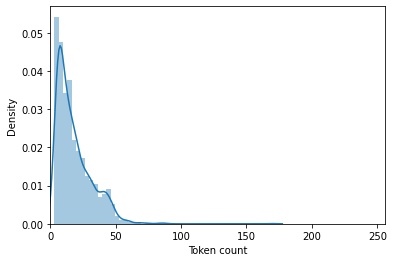

In [ ]:
token_lens = []
for txt in X:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))  

# Plot the distribution
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the texts appear to contain less than 60 tokens, but we’ll be on the safe side and choose a maximum length of 80.

In [ ]:
MAX_LEN = 80

Before performing tokenization on whole data. Let's load the BERT model for classification.

**Load the BertForSequenceClassification model**:

We’ll be using [BertForSequenceClassification](https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

In [ ]:
from transformers import BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-cased", # Use bert-base-spanish-wwm-cased pre-trained model
    num_labels = 8, # The number of  target classes = 8
)

# Tell pytorch to run this model on the GPU.
model = model.to(device)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

For the purposes of fine-tuning, the BERT authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):          

Batch size: 16, 32        
Learning rate (Adam): 5e-5, 3e-5, 2e-5       
Number of epochs: 2, 3, 4            

We used above values as a reference for hyperparameter tuning.

In [ ]:
# Set training parameters
batch_size = 32
learning_rate = 5e-5
epochs = 3
# We alread choosen max length of sequence
max_length = MAX_LEN

**Tokenize & Encode**

Let's tokenize the whole data. Since we are using Pytorch,we need to create a pytorch dataset for train & test sets. We will define a class named **text_Dataset** to create pytorch dataset. This class includes the tokenizer to tokenize the text into tokens.

In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
# Create a Pytorch Dataset

class text_Dataset(Dataset):

  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer=tokenizer
    self.max_length=max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,item):
    text = str(self.texts[item])
    labels = self.labels[item]

    encoding = self.tokenizer.encode_plus(
        text,
        max_length=max_length,
        add_special_tokens=True,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
       )
           
    return {
        'text':text,
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'labels' : torch.tensor(labels, dtype=torch.long)
    }

Let's also define a function named data_loader to load the data in batches. It takes features, labels, tokenizer, max length of the sequence & batch size as inputs.

In [ ]:
# Create the Data Loader
def data_loader(features, labels, tokenizer, max_length, batch):
  ds=text_Dataset(
      texts = np.array(features),
      labels = np.array(labels),
      tokenizer = tokenizer,
      max_length = max_length
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

# For train
train_DataLoader=data_loader(x_train, y_train, tokenizer, max_length, batch_size)
# For test
test_DataLoader=data_loader(x_test, y_test, tokenizer, max_length,batch_size)
# For validation
valid_DataLoader=data_loader(x_val, y_val, tokenizer, max_length, batch_size)

In [ ]:
# Check what is in the train_DataLoader
data = next(iter(train_DataLoader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])

# **Training**

So far, we prepared the data for model training. We will data loaders to load the data in batches to model for training, validation, & testing. Now, it's our turn to train the model & evaluate the model on validation to see how good our model is. Let's do that.

We need to define the optimizer & learning rate scheduler before training the model. We are using **AdamW** optimizer & **get_linear_schedule_with_warmup** rate scheduler for this task. Let's do that first.

In [ ]:
# Create optimizer 
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = learning_rate
                )
 
# Create the learning rate scheduler.
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_DataLoader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

**Define a helper function for calculating simple accuracy.**

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

**Helper function for formatting elapsed times as hh:mm:ss**

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

**Training the model**

In [ ]:
# Set the seed value all over the place to make this reproducible.
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_DataLoader):

        # Progress update every 40 batches.
        if step % 10 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_DataLoader), elapsed))

        # Unpack this training batch from our dataloader. 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        result = model(b_input_ids, 
                       attention_mask=b_input_mask, 
                       labels=b_labels)

        loss = result.loss
        logits = result.logits
        #print(loss.item())
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_train_loss+= loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_DataLoader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in valid_DataLoader:
        
        # Unpack this training batch from our dataloader. 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            result = model(b_input_ids,
                           attention_mask=b_input_mask,
                           labels=b_labels)

        # Get the loss and "logits" output by the model. 
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss+= loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(valid_DataLoader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(valid_DataLoader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    10  of     74.    Elapsed: 0:00:09.
  Batch    20  of     74.    Elapsed: 0:00:17.
  Batch    30  of     74.    Elapsed: 0:00:25.
  Batch    40  of     74.    Elapsed: 0:00:33.
  Batch    50  of     74.    Elapsed: 0:00:41.
  Batch    60  of     74.    Elapsed: 0:00:50.
  Batch    70  of     74.    Elapsed: 0:00:58.

  Average training loss: 1.47
  Training epcoh took: 0:01:01

Running Validation...
  Accuracy: 0.65
  Validation Loss: 1.03
  Validation took: 0:00:02

======== Epoch 2 / 3 ========
Training...
  Batch    10  of     74.    Elapsed: 0:00:09.
  Batch    20  of     74.    Elapsed: 0:00:17.
  Batch    30  of     74.    Elapsed: 0:00:25.
  Batch    40  of     74.    Elapsed: 0:00:34.
  Batch    50  of     74.    Elapsed: 0:00:42.
  Batch    60  of     74.    Elapsed: 0:00:50.
  Batch    70  of     74.    Elapsed: 0:00:59.

  Average training loss: 0.98
  Training epcoh took: 0:01:02

Running Validation...
  Accuracy: 0.72
 

**Training results**

Let's see the summary of the results:

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.47,1.03,0.65,0:01:01,0:00:02
2,0.98,0.85,0.72,0:01:02,0:00:02
3,0.67,0.85,0.71,0:01:01,0:00:02


Plot the training loss and validation loss to check for over-fitting:

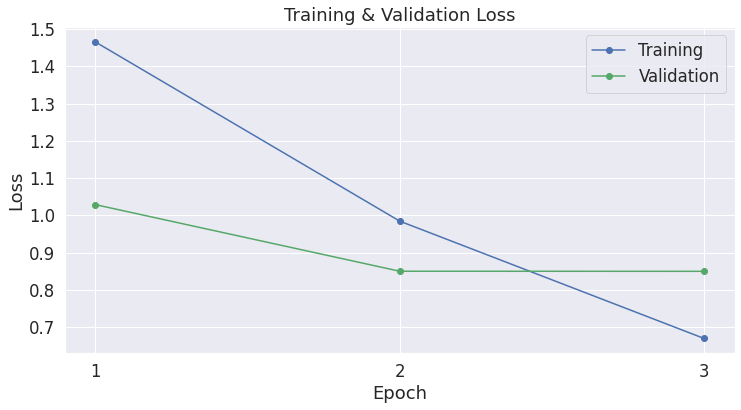

In [ ]:
# import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

We can see that the model is start overfitting in the middle of 2 epochs. So, we stop the training for 3 epochs.

**Model predictions on Test data**

In [ ]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_DataLoader:
  b_input_ids = batch['input_ids'].to(device)
  b_input_mask = batch['attention_mask'].to(device)
  b_labels = batch['labels'].to(device)
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('DONE.')

DONE.


In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)
flat_true_labels

array([3, 0, 0, 2, 3, 3, 0, 2, 4, 5, 0, 0, 3, 3, 0, 0, 2, 0, 0, 0, 4, 2,
       3, 0, 5, 3, 2, 0, 3, 6, 0, 0, 7, 0, 2, 0, 0, 7, 2, 0, 3, 1, 1, 7,
       1, 2, 3, 2, 0, 5, 5, 1, 0, 6, 6, 0, 2, 0, 5, 0, 4, 3, 0, 1, 2, 1,
       0, 0, 2, 2, 0, 0, 0, 0, 4, 4, 3, 2, 4, 0, 0, 0, 0, 5, 3, 0, 1, 0,
       0, 1, 0, 3, 1, 6, 1, 1, 5, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 1, 0, 0,
       2, 1, 5, 0, 1, 3, 3, 0, 2, 4, 2, 0, 0, 4, 0, 1, 0, 0, 0, 1])

**Confusion matrix**

['servicio', 'ux', 'funcionalidad', 'otro', 'revisar', 'error no reproducible', 'positivo', 'error reproducible']


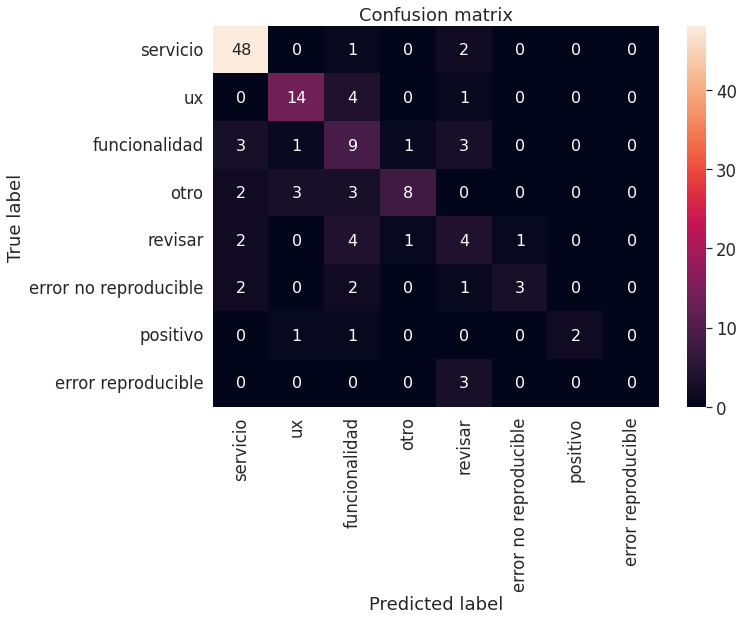

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns 
# Plot confusion matrix
cm = confusion_matrix(flat_true_labels, flat_predictions)
# Plot Confusion matrix
label_dict = {0:'servicio', 1:'ux', 2:'funcionalidad', 3:'otro', 4:'revisar', 5:'error no reproducible',
              6:'positivo', 7:'error reproducible'}
classes = list(label_dict.values())
print(classes)
df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes, fmt='g');
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

###The confusion matrix plotted above conveys as follows:
The elements in the principal digonal representes the correctly predicted classes. Apart from these elements, other elements represents the incorrect classification. These numbers should be reduced for better classification results. Out of 130 test samples, the model predicted 88 samples correctly & misclassified remaining 42 samples.

**Classification Report**

In [ ]:
classReport = classification_report(flat_true_labels, flat_predictions,target_names=[str(name) for name in classes])
print(classReport)

                       precision    recall  f1-score   support

             servicio       0.84      0.94      0.89        51
                   ux       0.74      0.74      0.74        19
        funcionalidad       0.38      0.53      0.44        17
                 otro       0.80      0.50      0.62        16
              revisar       0.29      0.33      0.31        12
error no reproducible       0.75      0.38      0.50         8
             positivo       1.00      0.50      0.67         4
   error reproducible       0.00      0.00      0.00         3

             accuracy                           0.68       130
            macro avg       0.60      0.49      0.52       130
         weighted avg       0.69      0.68      0.67       130



Insights:  
* Model is predicting well for classes servicio, & ux. But for other classes, model performance is not good. We can see that low precision, recall, & f1-score for these classes. This is due to the presence of imbalaced classes in the data during training. 
* We can also see f1-score as 0 for class **error reproducible**, this means the model not all learning this class during training. This is because the % of samples corresspond to this class is very low compared to other classes in the training data.
* We have done the hypertuning manually & found best training parameters as follows:   
epochs = 3, batch_size=32, & learning_rate = 5e-5.   
* We got the f1-score (weighted avg) of 0.67 & accuracy of 0.68.
* The model performance can be improved further by adding more data with balanced class distribution.